# Convolutional Neural Networks

This notebook makes extensive use of examples and figures from [here](http://cs231n.github.io/convolutional-networks/), which is a great reference for further details.

# Example: MNIST - Fashion

For this example we'll use MNIST- Fashion, a collection of small 28x28 pixel images of various pieces of clothing. It is a common benchmark along with with the orginal MNIST which is a collection of hand written digits. We will load the data directly from keras.

## The Goal
This is a multi-class classification problem, identify the type of object in the image
<table style="width:30%">
    <tr><th>Label<th>Class
    <tr><td>0 <td>T-shirt/top
    <tr><td>1 <td>Trouser'
    <tr><td>2 <td>Pullover
    <tr><td>3 <td>Dress
    <tr><td>4 <td>Coat
    <tr><td>5 <td>Sandal
    <tr><td>6 <td>Shirt
    <tr><td>7 <td>Sneaker
    <tr><td>8 <td>Bag
    <tr><td>9 <td>Ankle boot



## Image Data 

Here we'll rely on tensorflow and the handy package Keras that comes with it

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='' #If you installed tensorflow to work with a GPU this will disable it
import os.path
import shutil
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
n_targets=np.max(y_test)+1
print('Example Target',X_train[0])
print('Example Label', y_train[0])

Example Target [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1

* Note above that the labels are integers from 0-9
* Also note the images are integers from 0-255 (uint8)

We will deal with the labels first. Lets make some useful arrays and dictionaries to keep track of what each integer means 

In [3]:
# This is useful for making plots it takes an integer
lookup_dict={
    0:'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot' 
}


#Lets make a list in the order of the labels above so [T-Shirt,Trouser,...]
labels=list(lookup_dict.values())

#Check to make sure labels list is in the right order (not guarentted in python < 3.7)
if not all([v==lookup_dict[i] for i,v in enumerate(labels) ]):
    print('This looks like an old version of python making labels the long way')
    labels=['' for i in range(n_targets) ] #make a list with the right size
    for key in lookup_dict:
        labels[key]=lookup_dict[key] #Assign list to the vaules
        
#Always good to make simple checks that what you think is going to work actually is working
#Here we check that our array of labels is in the same order as the dictionary we wrote above
assert(all([v==lookup_dict[i] for i,v in enumerate(labels) ]))

#Another Simple Check (Keras is well tested this will work, but it's good to get in the habit when using your own data)
assert(len(X_train)==len(y_train))
assert(len(X_test)==len(y_test))





The results are stored as labels, but we'll want to work with a one-hot representation.  `keras` has a utility to make this conversion easy.

In [4]:
Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test =  tf.keras.utils.to_categorical(y_test, 10)

print('Example',y_train[0],'=',Y_train[0])

Example 9 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Now lets handle the image data
* Our Convolutional Neural Networks need a shape of Batch x Height X Width x Channels for us (28x28x1)
    * In this case channels=1, but for a color image you'll have 3 RGB and sometimes 4 with a transparency channel RGBA 
* It's much easier for a neural network to handel data with range from 0-1, rather than 0-255, so we will scale the data


uint8 255


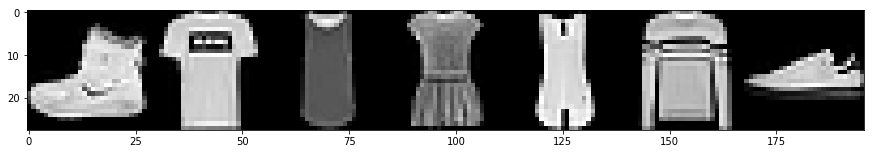

In [5]:

f=plt.figure(figsize=(15,3))
plt.imshow(np.squeeze(np.hstack(X_train[0:7])),cmap='gray') #hstack aranges the first 7 images into one long image

#Reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)


print(X_train.dtype, X_train.max())

#Notice that the pixel values imported as an integer array that saturates at `255`.  Let's turn the data into floats $\in [0, 1]$.

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

assert(np.max(X_train) <=1)
assert(np.max(X_test) <=1)


Now we're ready for some machine learning

## Dense (fully connect Neural Network Keras)

Lets try a simple fully connected network first to see how fast and accurate it is.
Recall the fully connected neural network.

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=300>

While useful these networks can become problematic for image data. Lets look an an example.

### Keras
We'll now build our model. A model in keras represents how to go from a set of inputs to a set of outputs, through a series of layers (For example CNN layers or fully connected layers).


In [6]:
input_layer=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
flat_input=tf.keras.layers.Flatten()(input_layer )#Dense layers take a shape of ( batch x features)
hidden_layer1=tf.keras.layers.Dense(100,activation='relu')(flat_input)
hidden_layer2=tf.keras.layers.Dense(100,activation='relu')(hidden_layer1)
output_layer=tf.keras.layers.Dense(n_targets,activation='softmax')(hidden_layer2)
dense_model=tf.keras.models.Model(input_layer,output_layer)

dense_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

dense_model.summary()

history=dense_model.fit(X_train, Y_train, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(X_test,Y_test)
         )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 136us/step - loss: 0.4955 -

The above network didn't work particularlly well, and while it's possible to get a network like this give you good accuracy it requires some work, tunning, and has a bigger issue. Look at the summary





our first layer has 28 * 28 * 1 * 100 = 78,500 weights, which is fine for this size image.  What about using even a low resloution image of 300 * 300 * 3 * 100= 27 Million parameters for one layer. This is still possible with modern GPUs, but dosen't general yeild good results. We need a solution that dosen't scale with with the number of pixels!

A 300x300x3 pixel Image
<img src=../assets/small_img.jpg width='100' >


# Convoluational Neural Networks


The fully connected neural network becomes cumbersome when we start considering image recognition; it needs *lots* of weights, and isn't designed to take advantage of spatial features in the inputs.  This is where CNNs become powerful.

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg" width=300>

CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and therefore weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" width=300>

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of neurons in the convolution layer is $(W−F+2P)/S+1$. 

<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

Above is a 1-D example with inputs on the bottom in gray ($W=5$), and two different examples of a convolutional layer in yellow, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 1$, meaning we need ($5 - 3 + 2)/1+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

### Parameter sharing

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2).

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the neurons in each depth slice to use the same weights and bias. All $7\times7$ neurons in each depth slice will now be using the same parameters.

<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">

## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width=300>

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width=500>

**NOTE**: These are being used less and less these days, in favor of other methods suCh as strided convolutions seen above.



Let's return to the MNIST hand-written digits data set.  First we'll download some external images that will be useful for visualizations later.

## The Model

We'll now build our model. A model in keras represents how to go from a set of inputs to a set of outputs, through a series of layers (For example CNN layers). Lets start by creating an input layer


In [7]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
print(cnn_input)

Tensor("input_2:0", shape=(?, 28, 28, 1), dtype=float32)


Our first layer (after the input layer) will be a convolutional layer with `32` filters. 

In [8]:
cnn_layer1=tf.keras.layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 

Just to demonstrate what's going on under the hood, we can print the current output shape of the model, which is the information that's fed into layers as we add them on.

In [9]:
print(cnn_layer1)

Tensor("conv2d/Relu:0", shape=(?, 26, 26, 32), dtype=float32)


Now let's add on another `32`-filter convolutional layer, following by a 2-D pooling layer with a pooling size of `2x2`.

In [10]:
cnn_layer2=tf.keras.layers.Convolution2D(32, (3, 3), activation='relu')(cnn_layer1)
max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)

Next we'll add on a *dropout* layer.  This layer will set the specified fraction of inputs to `0`, which can be useful for avoiding over fitting.  We'll drop $25\%$ of the inputs with this layer.   

In [11]:
dropout=tf.keras.layers.Dropout(0.25)(max_pool)

Next we'll add a fully connected layer with `128` nodes, making sure to flatten the volume before passing to this layer.

In [12]:
flat=tf.keras.layers.Flatten()(dropout)
dense1=tf.keras.layers.Dense(128, activation='relu')(flat)

We'll now add one final $25\%$ dropout layer for good measure, followed by the output layer.

In [13]:
dropout_output=tf.keras.layers.Dropout(0.5)(dense1)
output_no_activation=tf.keras.layers.Dense(n_targets, activation='softmax')(dropout_output)
output=tf.keras.layers.Activation('softmax')(output_no_activation)


# Building the Model
tf.keras.models.Model([input_layer],[output_layer])

In [14]:
model=tf.keras.models.Model([cnn_input],[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
__________

Now that we've built our full model it's time to compile it, specifying the loss function, optimizer, and any metrics we want to look at, and fit on the training data.

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
history=model.fit(X_train, Y_train, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(X_test,Y_test)
         )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 620us/step - loss: 1.6793 - acc: 0.7842 - val_loss: 1.6151 - val_acc: 0.8468
Epoch 2/10
60000/60000 [==============================] - 36s 608us/step - loss: 1.6155 - acc: 0.8461 - val_loss: 1.5969 - val_acc: 0.8629
Epoch 3/10
60000/60000 [==============================] - 37s 610us/step - loss: 1.6003 - acc: 0.8614 - val_loss: 1.5992 - val_acc: 0.8624
Epoch 4/10
60000/60000 [==============================] - 37s 612us/step - loss: 1.5920 - acc: 0.8691 - val_loss: 1.5998 - val_acc: 0.8615
Epoch 5/10
60000/60000 [==============================] - 37s 614us/step - loss: 1.5850 - acc: 0.8762 - val_loss: 1.5776 - val_acc: 0.8834
Epoch 6/10
60000/60000 [==============================] - 37s 614us/step - loss: 1.5814 - acc: 0.8790 - val_loss: 1.5711 - val_acc: 0.8890
Epoch 7/10
60000/60000 [==============================] - 37s 613us/step - loss: 1.5767 - acc: 0.8839 - val_loss: 1.

In [17]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("loss: {}, accuracy: {}".format(*score))

loss: 1.569655533027649, accuracy: 0.8915


Exccellent we've trained a model with good accuracy, now lets check it for some common issues like overfitting, and see what images are the most difficult to deal with.

# Overfitting

Overfitting generally refers to a tendy for ML models to find an exploiting statistical fluctuaions in your training data that don't accurately reflect the system you're trying to learn. You can think of this a 'memorizing' without any real understanding. A good way of testing whether this is happening or not is to compare the training loss to the loss calculated on a new set of data (with it's own different statistical fluctuations)

* Overfitting is combated with Dropout (more on that later)

Keras's fit function returns a history object that shows the loss of the training and testing set we can check it for signs of overfitting.

* You expect for the training and testing loss to go down 
* If the model starts overfitting 
    * you'll see the testing loss stop decreasing and even go up 
    * Training loss will continue to go down
* An important detail: Keras has two learning_phases
    * Training: The Model is training and dropout is on reducing avliable information
    * Testing: This is the setting when using the model for real, dropout is disabled
    * The Training loss is calculated with the training phase (dropout on)
    * The Testing loss is calculated with the testing phase (dropout off)
        * You will often see the Training loss is greater than the testing loss, this is okay if you're using dropout
        * It might not be okay if you're using your own data without dropout
            * Could be a sign the testing data is distributed differently than the training data

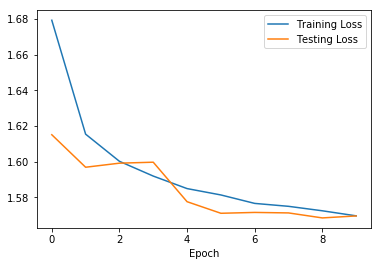

In [18]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

Any sign of overfitting?

In [21]:
# Prediction


T-shirt/top 8.53 %
Trouser 8.53 %
Pullover 8.53 %
Dress 8.53 %
Coat 8.53 %
Sandal 8.53 %
Shirt 8.53 %
Sneaker 8.53 %
Bag 8.53 %
Ankle boot 23.2 %
best guess: Ankle boot


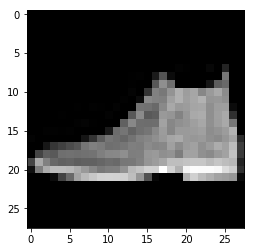

Truth Class: 9 Ankle boot


In [33]:
pred=model.predict(X_test)
for i,p in enumerate(pred[0]):
    print(lookup_dict[i],round(p*100,2),'%')

best_guess=np.argmax(pred[0])
print('best guess:',lookup_dict[best_guess])
plt.imshow(np.squeeze(X_test[0]),cmap='gray')
plt.show()

print('Truth Class:',y_test[0],lookup_dict[y_test[0]])


(10000, 10)


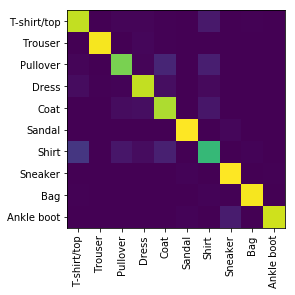

Number of Incorrect Guesses: 1085


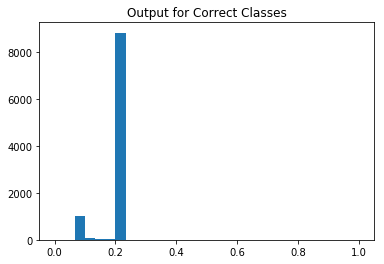

Guess: T-shirt/top /Truth: Dress


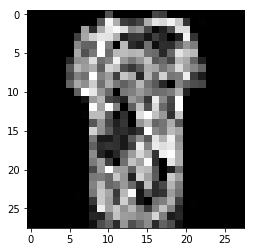

Guess: Pullover /Truth: Shirt


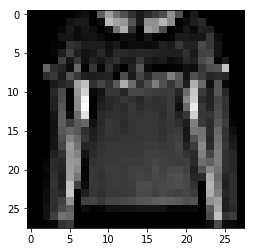

Guess: Trouser /Truth: Dress


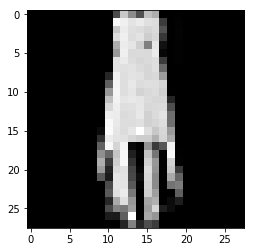

Guess: Coat /Truth: Shirt


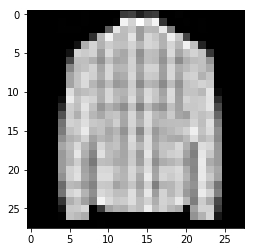

Guess: Shirt /Truth: Pullover


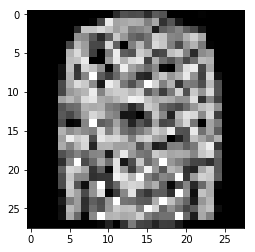

In [34]:
def check(model,X_test,Y_test):
    pred=model.predict(X_test)
    print(pred.shape)
    best_guess=np.argmax(pred,axis=1)

    confusion_matrix=np.zeros((n_targets,n_targets))
    for truth,guess in zip(y_test,best_guess): #Note lower case y for the data without 1-hot encoding    
        confusion_matrix[truth,guess]+=1

    plt.imshow(confusion_matrix)
    plt.xticks(range(0,10),labels,rotation=90)
    plt.yticks(range(0,10),labels)

    plt.show()
    print('Number of Incorrect Guesses:',np.sum(best_guess!=y_test))

    
    prediction_for_true_value=[p[i] for p,i in zip(pred,y_test)  ]

    bins=plt.hist(prediction_for_true_value,bins=30,range=(0,1))
    plt.title('Output for Correct Classes')
    
    worst=np.argsort(prediction_for_true_value)


    plt.show()
    plt.show()

    for index in worst[0:5]:
        print("Guess:", lookup_dict[best_guess[index]], "/Truth:",lookup_dict[y_test[index]])
        plt.imshow(np.squeeze(X_test[index]),cmap='gray')

        plt.show()


check(model,X_test,Y_test)




In [ ]:
pred[0],best_guess[0]

In [ ]:
#Lets Put of this together into some helpful functions
def build_model(dropout_rate=0.25,nfilters=32,use_leakyRelu=False,activation='relu'):
    if use_leakyRelu:
        activation='linear'
    
    cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
    cnn_layer1=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 
    if use_leakyRelu:cnn_layer1=tf.keras.layers.LeakyReLU()(cnn_layer1)
    cnn_layer2=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_layer1)
    if use_leakyRelu:cnn_layer2=tf.keras.layers.LeakyReLU()(cnn_layer2)

    max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)
    dropout=tf.keras.layers.Dropout(dropout_rate)(max_pool)
    flat=tf.keras.layers.Flatten()(dropout)
    
    dense1=tf.keras.layers.Dense(128, activation=activation)(flat)

    dropout_output=tf.keras.layers.Dropout(dropout_rate)(dense1)
    output_no_a=tf.keras.layers.Dense(10)(dropout_output)
    output=tf.keras.layers.Activation('softmax')(output_no_a)
    model=tf.keras.models.Model([cnn_input],[output])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model
    
def plot_history(history):
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    

# Dropout
Try a model without dropout

In [ ]:
import numpy as np
print(X_train.shape)
train_data=np.random.choice(range(0,len(X_train))  ,500 )

In [ ]:

for rate in [0,0.5,0.7,0.9]:
    new_model=build_model(dropout_rate=rate)
    print('Dropout Rate ',rate)
    history=new_model.fit(X_train[train_data], Y_train[train_data], 
          batch_size=32, epochs=200, verbose=0,
         validation_data=(X_test,Y_test) )
    score = new_model.evaluate(X_test, Y_test, verbose=0)
    print("Test loss: {}, Test accuracy: {}".format(*score))

    score = new_model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
    print("Train loss: {}, Train accuracy: {}".format(*score))

    
    plot_history(history)


In [ ]:
validation_data=(X_test,Y_test) 
score = new_model.evaluate(X_test, Y_test, verbose=0)
print("loss: {}, accuracy: {}".format(*score))

In [ ]:
check(new_model,X_test,Y_test)

In [ ]:
np.max(grads)


In [ ]:
# Activations


In [ ]:
x=np.expand_dims(np.linspace(-10,10,50),1)

act_input=tf.keras.Input((1,)) #Notice the comma after 1, this is a 1 dimentional input to keras
output=tf.keras.layers.LeakyReLU()(act_input) #This is an "Advanced Activation, so it has it's own layer"


sess=tf.keras.backend.get_session()
output=sess.run(output,feed_dict={act_input:x})
plt.plot(x,output)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('LeakyReLU')
plt.show()
for activation in ['elu','selu','relu','softplus','softsign','tanh','sigmoid','hard_sigmoid','linear']:
    output=tf.keras.layers.Activation(activation)(act_input) 
    sess=tf.keras.backend.get_session()
    output=sess.run(output,feed_dict={act_input:x})
    plt.plot(x,output)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(activation)
    plt.show()


In [ ]:
#Sigmoid

In [ ]:
model=build_model(dropout_rate=0.50,nfilters=32,activation='sigmoid')
history=model.fit(X_train, Y_train, 
      batch_size=32, epochs=10, verbose=0,
     validation_data=(X_test,Y_test) )
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_test,Y_test)
plot_history(history)

In [ ]:
#Leaky RELU

In [ ]:
model=build_model(dropout_rate=0.50,nfilters=32,use_leakyRelu=True)
history=model.fit(X_train, Y_train, 
      batch_size=32, epochs=10, verbose=0,
     validation_data=(X_test,Y_test) )
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_test,Y_test)
plot_history(history)

# Something a bit more complicated

Even when over fitting we can see 

In [ ]:
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
n_targets=np.max(y_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255




In [ ]:
f=plt.figure(figsize=(15,3))
plt.imshow(np.hstack(X_train[0:7]),cmap='gray') #hstack aranges the first 7 images into one long image